<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-KevinBCruzMejia/blob/main/TecMty_kmeans_target_A01794176.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Ciencia y analítica de datos**
###Tecnológico de Monterrey
###Profesora: Dra. María de la Paz Rico Fernández
####Fecha: 09/11/2022
## **Adtividad de la Semana 7**
###**Notebook 2. K means**

**Nombre y matrícula del estudiante:**

*   Kevin Brandon Cruz Mejia - A01794176

**Link:**
* https://github.com/PosgradoMNA/actividades-de-aprendizaje-KevinBCruzMejia/blob/main/TecMty_kmeans_target_A01794176.ipynb

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

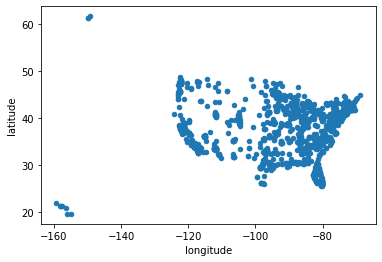

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [11]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [12]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [13]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

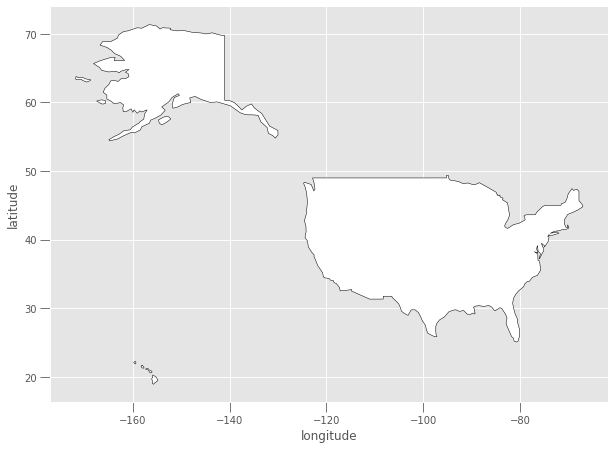

In [15]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

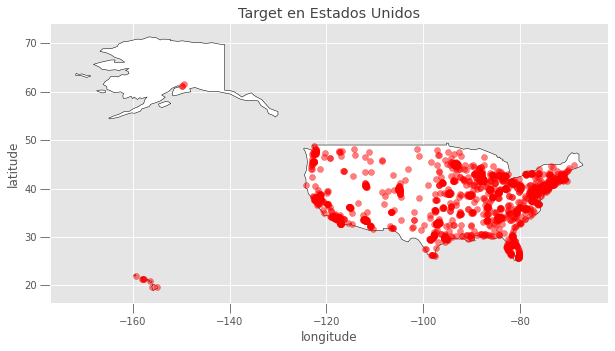

In [16]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [17]:
X=df[["longitude","latitude"]]

Obtener el numero de K por una curva de codo

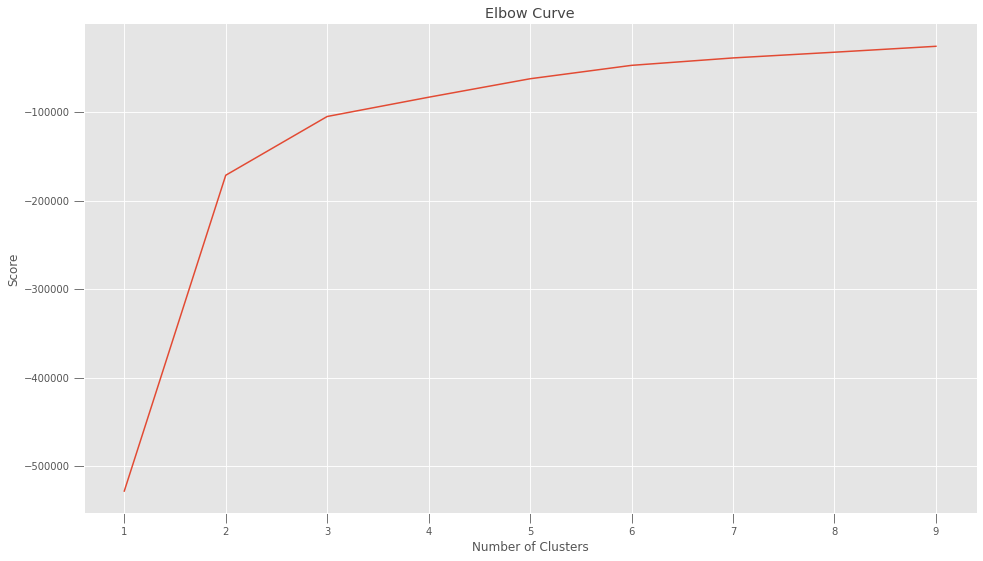

In [18]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Se observa la curva con un codo entre dos y  cuatro. Considero a 4 como un buen número para K.

In [19]:
#tu codigo aquí
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

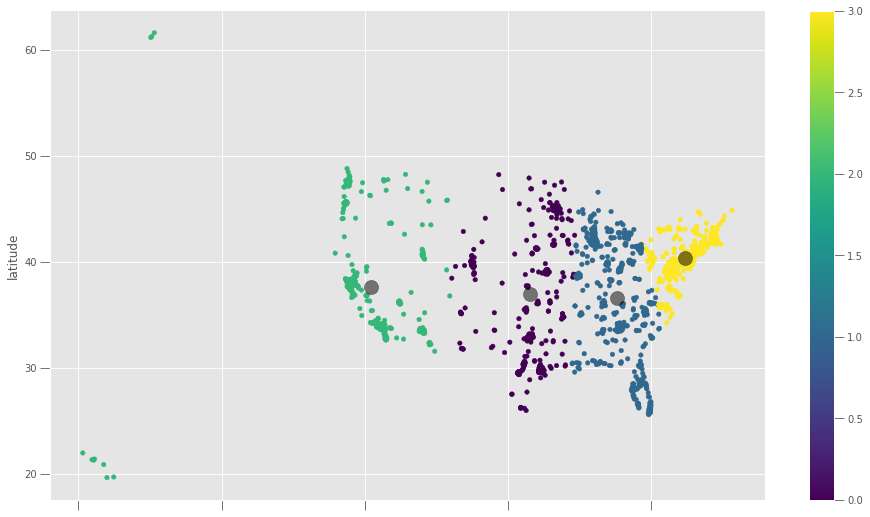

In [20]:
#latlong.plt.scatter( c=y_kmeans, s=50, cmap='viridis')
latlong.plot.scatter( "longitude","latitude",c=y_kmeans, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [21]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ -96.97278809   36.99505521]
 [ -84.80260815   36.55629613]
 [-119.14645561   37.57757741]
 [ -75.26720102   40.34198355]]


In [22]:
for lat,longi in centroids:
  print(lat,longi)


-96.97278808975 36.99505520875
-84.80260815324675 36.556296130681815
-119.14645561138212 37.57757741219512
-75.26720101629957 40.34198355132158


In [23]:
df_centroid = pd.DataFrame(centroids,columns={"Latitude ","Longitude"})
df_centroid=df_centroid.astype(str)
df_centroid.dtypes

Latitude     object
Longitude    object
dtype: object

In [24]:
from pickle import LONG_BINGET
# import module
from geopy.geocoders import Nominatim
 
# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")
 
for longi, lat in centroids:
  # Latitude & Longitude input
  Latitude = lat.astype(str)
  Longitude = longi.astype(str)
  
  location = geolocator.reverse(Latitude+","+Longitude)
  
  address = location.raw['address']
  
  # traverse the data
  city = address.get('city', '')
  state = address.get('state', '')
  country = address.get('country', '')
  code = address.get('country_code')
  zipcode = address.get('postcode')
  print('City : ', city)
  print('State : ', state)
  print('Country : ', country)
  print('Zip Code : ', zipcode)

City :  
State :  Kansas
Country :  United States
Zip Code :  None
City :  
State :  Tennessee
Country :  United States
Zip Code :  None
City :  
State :  California
Country :  United States
Zip Code :  None
City :  Hilltown Township
State :  Pennsylvania
Country :  United States
Zip Code :  18962


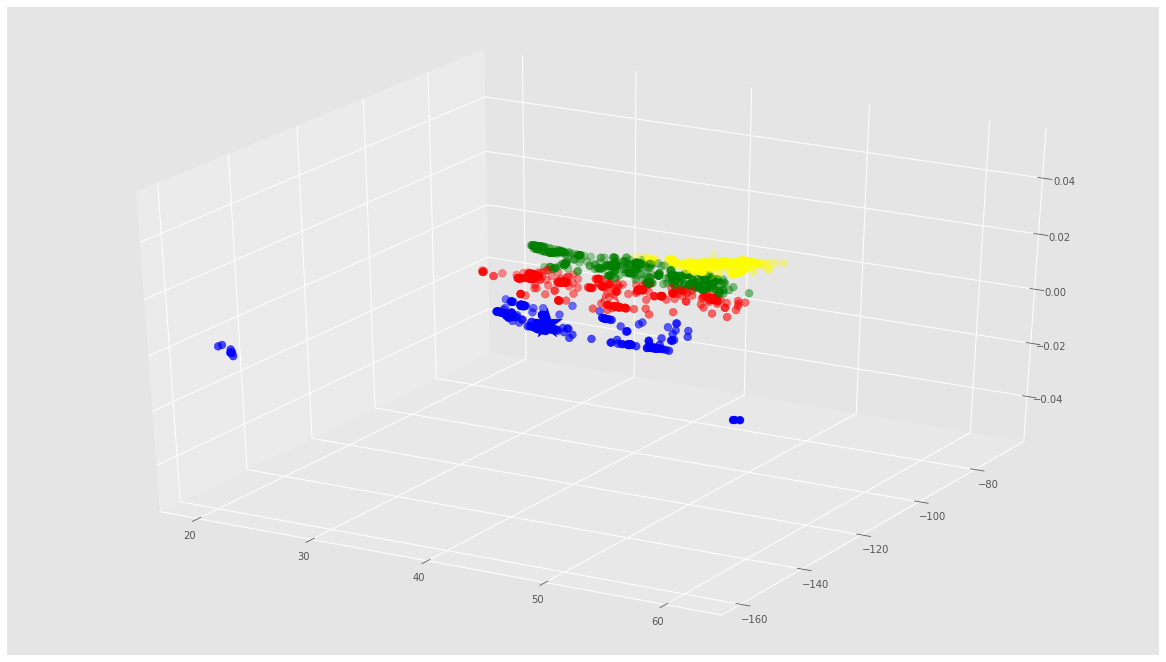

In [25]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X.latitude,X.longitude, c=asignar,s=60)
ax.scatter(C[:, 1],C[:, 0], marker='*', c=colores, s=1000)

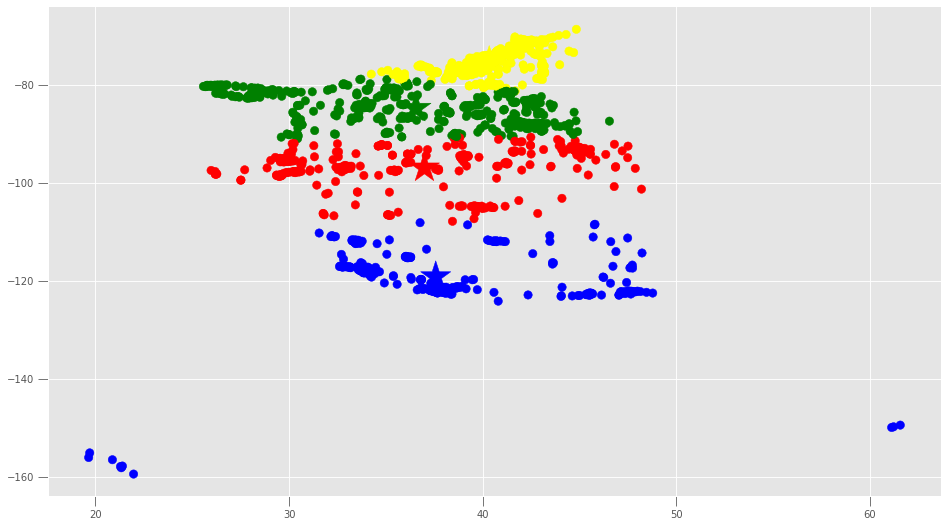

In [26]:
# Getting the values and plotting it
f1 = df['latitude'].values
f2 = df['longitude'].values

plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 1], C[:, 0], marker='*', c=colores, s=1000)
plt.show()

Obtenemos el numero de tiendas por el color de los clustes asociados a los centroides

In [27]:
copy =  pd.DataFrame()
copy['latitude']=df['latitude'].values
copy['longitude']=df['longitude'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,401
1,green,615
2,blue,369
3,yellow,454


* Encuentra el numero ideal de almacenes, justifica tu respuesta:
  * El numero ideal de almacenes son 4 en estados unidos para el centro y Alaska y en Hawai o donde la isla inferior izquierda

* Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?
  * Latidude____    Longitude
  * -96.95719875,   37.00876203 -> State :  Kansas
  * -75.26720102,   40.34198355 -> City :  Hilltown Township, State :  Pennsylvania, Zip Code :  18962
  * -119.14645561,   37.57757741 -> State :  California
  *  -84.792984.    36.54664541 -> State :  Tennessee
* ¿a cuantas tiendas va surtir? 
  * Latidude____    Longitude
  * -96.95719875,   37.00876203 -> 401
  * -75.26720102,   40.34198355 -> 615
  * -119.14645561,   37.57757741 -> 369
  *  -84.792984.    36.54664541 -> 454

* ¿sabes a que distancia estará?
 
  * R. No, pero al tener longitud y latitud de los almacenes o tiendas, por la formula de distancia entre las dos rectas, con kmeans es posible saberlo
* ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.
  * R. Por la curva de codo, donde se ubica el codo podemos analizar el mejor numero de clusters que son nuestros almacenes, ya que despues de este punto la grafica se estabiliza y no hace diferencia sumar mas cluster o caso contrario antes del codo no es suficiente para el numero de tiendas


Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

* ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
  Las librerias de Geographic Information System (GIS) son varias de las que podemos mencionar son:
   1. Arcpy
   2. GDAL/OGR
   3. RSGISLib
   4. PyProj
* ¿Consideras importante que se grafique en un mapa?, ¿por qué?
  En este caso y en la mayoria donde podemos implementar Kmeans es importante porque nos ayuda al analisis de como se distribuye los clusters que se van formando alrededor del centroide, asi podemos decidir el numero de clusters que mejor se adapten a nuestras necesidades, e inclusive como en este caso al parecer habia ouliers lo que realmente no es asi, entonces una estrategia es segmentar la base de datos para ese caso y verificar si entra o no para otro analisis por la cantidad de informacion que la hace apreciar de forma alejada.


##Agrega las conclusiones

En esta actividad mis conclusiones son:
* Es importante la parte grafica en este caso usar GIS para no despreciar informacion valiosa que esta bien estructurada
* Kmeans es realizar clusters y realiza centroides que es donde se concentra mas la informacion
* Tenemos que analizar nuestros datos tanto graficamente como en la problematica a resolver para saber cuantos clusters implementar
* Con los colores, bordes, y demas tecnicas para visualizar los datos, podemos aprectiar si se esta realizando bien el modelo con kmeans
* Kmeans una de sus bases es encontrar el vecino mas cercano por lo que podemos saber la distancia del clusters con los demas elementos que lo conforman
* Este tipo de tecnica se apoya en la parte visual, analisis, datos , etc, lo que la hace mas dinamica al momento de comparar resultados, y esto ayuda porque es con aprendizaje no supervisado, lo que no tenemos una variable dependiente o una Y/target para verificar.